In [1]:
#YouTube Data Scraping, Preprocessing and Analysis using Python


In [2]:
#Installing Required Libraries for Webscraping
!pip install requests beautifulsoup4 xlsxwriter -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.5 MB/s eta 0:00:00


In [3]:
import requests
from bs4 import BeautifulSoup
import json
import xlsxwriter
import regex as re

In [4]:
url = "https://www.youtube.com/c/GeeksforGeeksVideos/videos"
headers = {"User-Agent": "Mozilla/5.0"}
#Here we added a user agent "Mozilla/5.0" pretends the request is from a browser,it doesn't act as a bot ,unlikely to block our request.

Page_data = requests.get(url, headers=headers)
html = Page_data.text

In [5]:
#creating a parser to navigate through elements
soup = BeautifulSoup(html, "html.parser")

In [6]:
script_tag = soup.find("script", text=lambda t: t and "ytInitialData" in t)
if script_tag:
  script_text=script_tag.string
  match=re.search(r"ytInitialData\s*=\s*(\{.*\})",script_text)
  if match: # This block is now nested correctly
    json_text=match.group(1)
    data=json.loads(json_text)

/tmp/ipython-input-2732728720.py:1: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script_tag = soup.find("script", text=lambda t: t and "ytInitialData" in t)


In [7]:
# Navigating to Video Metadata
#nested JSON structure is traversed to locate the section containing individual video metadata using Python Keys.


In [8]:
#This code cell is to identify that "videos" exist at index position "1" in the list(tabs)
tabs=data["contents"]["twoColumnBrowseResultsRenderer"]["tabs"]
print(len(tabs))
for i,tab in enumerate(tabs):
  if "tabRenderer" in tab:
    print(i,tab["tabRenderer"]["title"])
  elif "expandableTabRenderer" in tab:
    print(i,tab["expandableTabRenderer"]["title"])
  else:
    print(i, "Title not found")

8
0 Home
1 Videos
2 Shorts
3 Live
4 Courses
5 Playlists
6 Posts
7 Search


In [9]:
#From the above output we know that second tab contains video data
#This is how we navigate to the videos data
#print(data['contents']['twoColumnBrowseResultsRenderer']['tabs'][1]\
 #             ['tabRenderer'].keys())
#print(data['contents']['twoColumnBrowseResultsRenderer']['tabs'][1]\
 #['tabRenderer']['content'].keys())
#print(data['contents']['twoColumnBrowseResultsRenderer']['tabs'][1]\
 #['tabRenderer']['content']['richGridRenderer'].keys())



In [10]:
videos_data = data['contents']['twoColumnBrowseResultsRenderer']['tabs'][1]\
              ['tabRenderer']['content']['richGridRenderer']['contents']

In [11]:
titles, views, durations,Published_data = [], [], [],[]
count = 0

for item in videos_data:
    try:
        video = item['richItemRenderer']['content']['videoRenderer']
        #print(video)
        titles.append(video['title']['runs'][0]['text'])
        views.append(video.get('viewCountText', {}).get('simpleText', 'N/A'))
        durations.append(video.get('lengthText', {}).get('simpleText', 'N/A'))
        Published_data.append(video.get('publishedTimeText', {}).get('simpleText', 'N/A'))

        count += 1
        if count >= 30:
            break
    except:
        continue

In [12]:
#Creating a new workbook and adding headers to the worksheet
workbook = xlsxwriter.Workbook("youtube_videos.xlsx")
sheet = workbook.add_worksheet()

sheet.write(0, 0, "Title")
sheet.write(0, 1, "Views")
sheet.write(0, 2, "Duration")
sheet.write(0, 3,"Published_Time")

0

In [13]:
#Writing data to the workbook
for i in range(len(titles)):
    sheet.write(i+1, 0, titles[i])
    sheet.write(i+1, 1, views[i])
    sheet.write(i+1, 2, durations[i])
    sheet.write(i+1, 3, Published_data[i])

In [14]:
workbook.close()
print("Scraped latest 30 videos successfully! Saved as youtube_videos.xlsx")

Scraped latest 30 videos successfully! Saved as youtube_videos.xlsx


In [15]:
#Data Preprocessing


In [16]:
import pandas as pd

data = pd.read_excel("youtube_videos.xlsx")
data.head()

,Title,Views,Duration,Published_Time
0,TCS NQT 2026 | How To register? | How To Apply...,"1,068 views",7:12,18 hours ago
1,All About TCS NQT 2026 | Syllabus | Cut Off | ...,"11,886 views",10:05,5 days ago
2,What is SQL? 🤔 Future Career Scope & Best Reso...,"2,028 views",11:56,9 days ago
3,DSA In Java | Graph 01 | Java in One Shot | Gr...,"3,936 views",5:00:22,12 days ago
4,250+ Refunds Claimed | GeeksforGeeks Three 90 ...,"6,691 views",0:50,13 days ago


In [17]:
#Cleaning the views column
#Removing the suffix text "views" in the column
#Converting the values to numeric if ending with "K"(2.6K)
#Converting the numeric string(number) to float
#Setting Missing Entries to None


In [18]:
# Removing "views" from the column
data['Views'] = data['Views'].str.replace(" views", "", regex=False).str.strip()
cleaned_views = []

for i in data['Views']:
    if pd.isna(i):
        cleaned_views.append(None)
        #Setting the missing values to "None"
        continue

    i = str(i).replace(",", "")

    if i.endswith('K') or i.endswith('k'):
        i = i.replace('K', '').replace('k', '')
        # Removing "K" from the views
        try:
            cleaned_views.append(float(i) * 1000)
            #Multipling the number with "1000" to get the exact numeric value and assigning the result to a new list variable
        except:
            cleaned_views.append(None)

    else:
        try:
            cleaned_views.append(float(i))
            #Converting the numeric string to float
        except:
            cleaned_views.append(None)

data['Views'] = cleaned_views

In [19]:
# Cleaning the Duration Column
#Removes newline characters.
#Converts durations to total seconds.
#Sets invalid or missing entries to None.

In [20]:
data['Duration'] = data['Duration'].str.replace("\n", "", regex=False)
#removes new line character
def duration_to_seconds(duration_str):
    if pd.isna(duration_str) or duration_str in ['SHORTS', 'N/A']:
        return None
    parts = str(duration_str).split(':')
    if len(parts) == 3:
        h, m, s = map(int, parts)
        return h * 3600 + m * 60 + s
    elif len(parts) == 2:
        m, s = map(int, parts)
        return m * 60 + s
    return None

data['Duration'] = data['Duration'].apply(duration_to_seconds)

In [21]:
# Cleaning the Published_Time column
#Removing the suffix text "ago" in the column
#Converting all Pub_Time to Days
#Sets invalid or missing entries to None.

In [22]:
data['Published_Time'] = data['Published_Time'].str.replace("ago", "", regex=False).str.strip()
cleaned_Time = []
for i in data['Published_Time']:
    if pd.isna(i):
        cleaned_Time.append(None)
        continue

   # i = str(i).replace(",", "")

    if "weeks" in i:

        try:
            i = i.replace('weeks', '')
            cleaned_Time.append(int(i) * 7)

        except:
            cleaned_Time.append(None)
    elif "month" in i:
        try:

            i = i.replace('month', '')
            cleaned_Time.append(int(i) * 30)
        except:
            cleaned_Time.append(None)
    else:
        try:
            i = i.replace('days', '')
            cleaned_Time.append(int(i))
        except:
            cleaned_Time.append(int(0))

data['Published_Time'] = cleaned_Time

In [23]:
data.head()

,Title,Views,Duration,Published_Time
0,TCS NQT 2026 | How To register? | How To Apply...,1068.0,432,0
1,All About TCS NQT 2026 | Syllabus | Cut Off | ...,11886.0,605,5
2,What is SQL? 🤔 Future Career Scope & Best Reso...,2028.0,716,9
3,DSA In Java | Graph 01 | Java in One Shot | Gr...,3936.0,18022,12
4,250+ Refunds Claimed | GeeksforGeeks Three 90 ...,6691.0,50,13


In [24]:
#Categorizing Videos by Duration#

In [25]:
for i in data.index:
    val = data.loc[i, 'Duration']

    if val is None:
        continue
    elif val < 900:
        data.loc[i, 'Duration'] = 'Mini-Videos'
    elif val < 3600:
        data.loc[i, 'Duration'] = 'Long-Videos'
    else:
        data.loc[i, 'Duration'] = 'Very-Long-Videos'

data.head()

/tmp/ipython-input-4002048857.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mini-Videos' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, 'Duration'] = 'Mini-Videos'


,Title,Views,Duration,Published_Time
0,TCS NQT 2026 | How To register? | How To Apply...,1068.0,Mini-Videos,0
1,All About TCS NQT 2026 | Syllabus | Cut Off | ...,11886.0,Mini-Videos,5
2,What is SQL? 🤔 Future Career Scope & Best Reso...,2028.0,Mini-Videos,9
3,DSA In Java | Graph 01 | Java in One Shot | Gr...,3936.0,Very-Long-Videos,12
4,250+ Refunds Claimed | GeeksforGeeks Three 90 ...,6691.0,Mini-Videos,13


In [26]:
#Text Preprocessing(mostly used text analysis, sentiment analysis or machine learning models)
#text is normalized, clean and meaningful reducing noise and irrelevant information.


In [27]:
import re
from tqdm import tqdm
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [28]:
# Initializing Stopwords and Stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [29]:
#Defining the Text Preprocessing Function
#Lowercasing
#Removing URLs
#Removing non-alphabetic characters
#Tokenization
#Stopword Removal and Stemming: filters out irrelevant words and reduces words to their root form.
#Joining tokens


In [30]:
def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        sentence = str(sentence).lower()

        sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence)

        sentence = re.sub(r'[^a-z0-9\s]', '', sentence)
        # usually used in text processing not required as of now,if applied, title not making sense
        #tokens = word_tokenize(sentence)

        #tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

        #preprocessed_text.append(" ".join(tokens))
        preprocessed_text.append(sentence)

    return preprocessed_text

In [31]:
data['Title'] = preprocess_text(data['Title'].values)
data.head()

100%|██████████| 30/30 [00:00<00:00, 44971.09it/s]


,Title,Views,Duration,Published_Time
0,tcs nqt 2026 how to register how to apply f...,1068.0,Mini-Videos,0
1,all about tcs nqt 2026 syllabus cut off eli...,11886.0,Mini-Videos,5
2,what is sql future career scope best resourc...,2028.0,Mini-Videos,9
3,dsa in java graph 01 java in one shot graph...,3936.0,Very-Long-Videos,12
4,250 refunds claimed geeksforgeeks three 90 ch...,6691.0,Mini-Videos,13


In [32]:
# data Visualisation

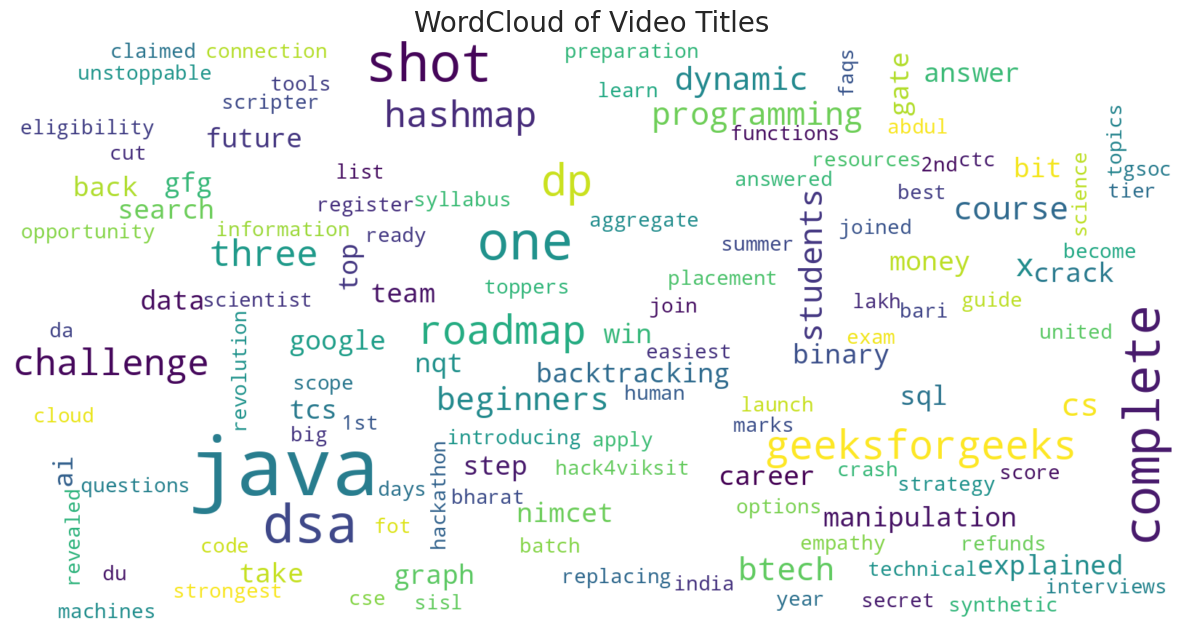

In [33]:
#Word Cloud of Video Titles
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

consolidated = ' '.join(word for word in data['Title'].astype(str))

wordCloud = WordCloud(
    width=1600,
    height=800,
    random_state=21,
    max_font_size=110,
    collocations=False,
    background_color='white'
)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Video Titles", fontsize=20)
plt.show()

/tmp/ipython-input-2151593455.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


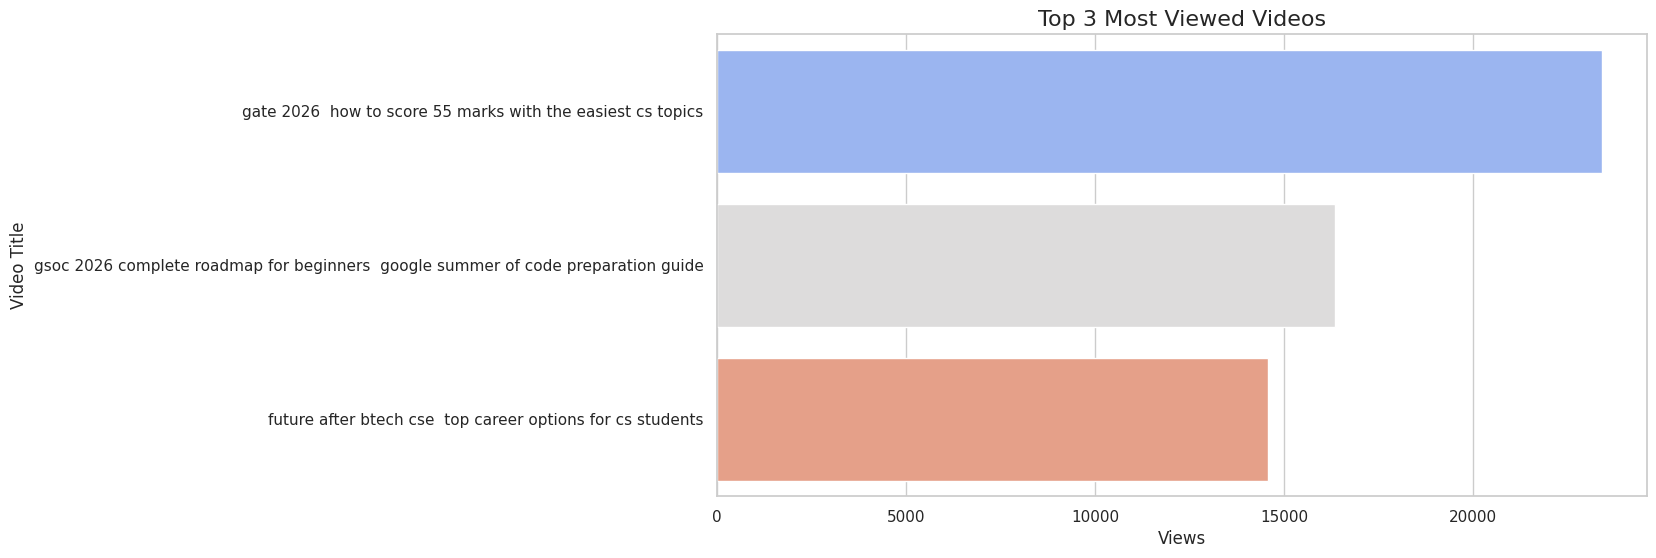

In [34]:
#Bar plot-Top 3 Most Viewed Videos
top_videos = data.sort_values(by='Views', ascending=False).head(3)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='Views',
    y='Title',
    data=top_videos,
    palette='coolwarm'
)
plt.title("Top 3 Most Viewed Videos", fontsize=16)
plt.xlabel("Views")
plt.ylabel("Video Title")
plt.show()


/tmp/ipython-input-4201521899.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


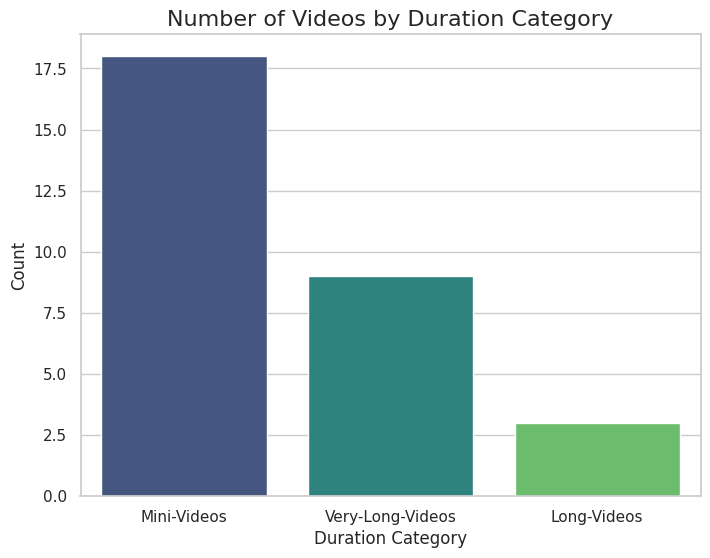

In [35]:
#Count Plot_ Video Count by Duration Category
plt.figure(figsize=(8, 6))
sns.countplot(
    x='Duration',
    data=data,
    palette='viridis',
    order=data['Duration'].value_counts().index
)
plt.title("Number of Videos by Duration Category", fontsize=16)
plt.ylabel("Count")
plt.xlabel("Duration Category")
plt.show()

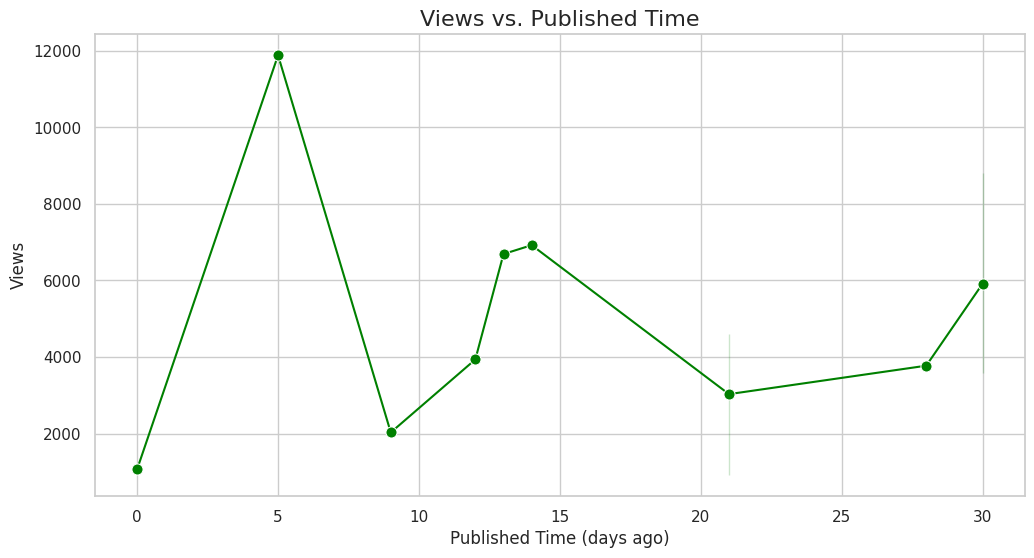

In [36]:
# Line Plot to visualise Views alongwith Published_Time
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='Published_Time',
    y='Views',
    data=data,
    marker='o',
    color='green',
    markersize=8
)
plt.title("Views vs. Published Time", fontsize=16)
plt.ylabel("Views")
plt.xlabel("Published Time (days ago)")
plt.show()

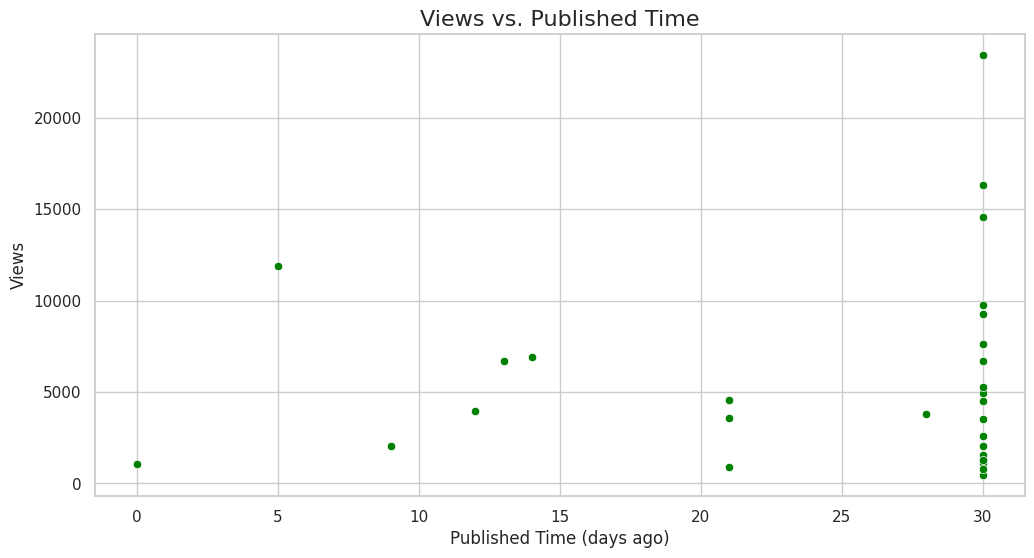

In [37]:
#ScatterPlot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Published_Time',
    y='Views',
    data=data,
    #marker='o',
    color='green',
    #markersize=8
)
plt.title("Views vs. Published Time", fontsize=16)
plt.ylabel("Views")
plt.xlabel("Published Time (days ago)")
plt.show()

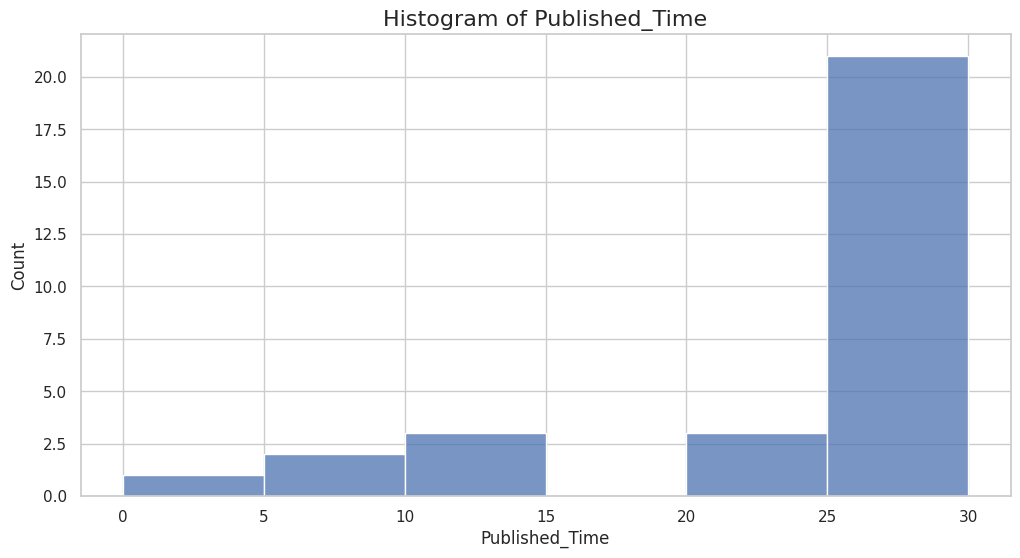

In [38]:
#Histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    x='Published_Time',
    data=data,
)
plt.title("Histogram of Published_Time", fontsize=16)
#plt.xlabel("Views")
plt.show()

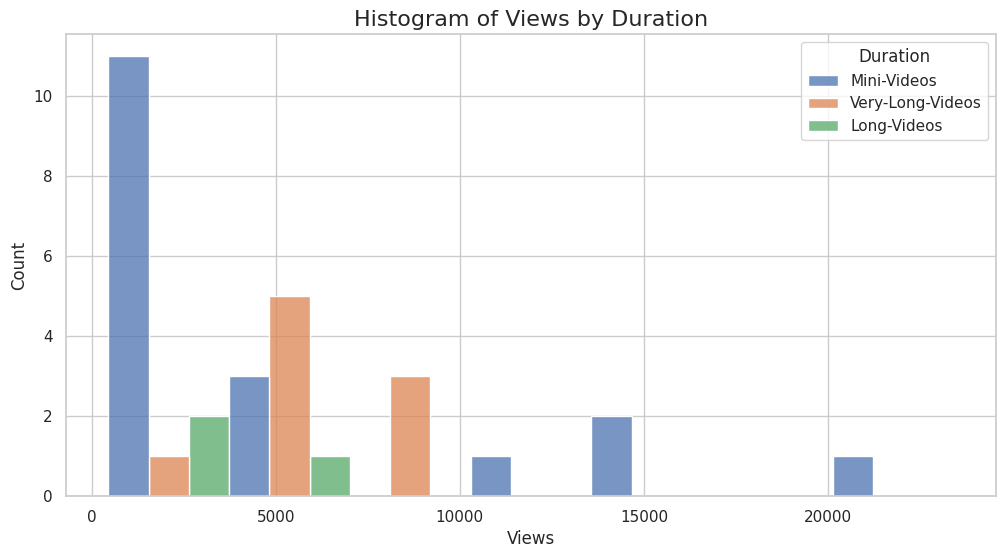

In [39]:
plt.figure(figsize=(12, 6))
sns.histplot(
    x='Views',
    hue='Duration',
    data=data,
    multiple='dodge'
)
plt.title("Histogram of Views by Duration", fontsize=16)
plt.xlabel("Views")
plt.show()

Duration
Mini-Videos         18
Very-Long-Videos     9
Long-Videos          3
Name: count, dtype: int64


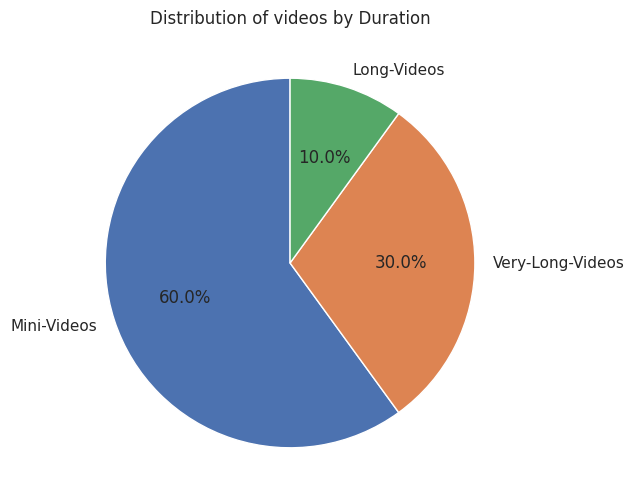

In [40]:
#Piechart to plot the ratio of videos
Duration_Time=data['Duration'].value_counts()
print(Duration_Time)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.pie(Duration_Time,
        labels=Duration_Time.index,
        autopct='%1.1f%%',
        startangle=90,
        )
plt.title("Distribution of videos by Duration")
plt.show()